In [1]:
import torch
import torchaudio.transforms as T
import torch.nn.functional as F

import os
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import HTML


from sincnet.model import (
    SincNet, Tokenizer,
    compute_forward_mu_law_companding, compute_backward_mu_law_companding, 
    compute_forward_mu_law_quantize, compute_backward_mu_law_quantize
)

from datasets.utils.waveform import WaveformLoader

In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [3]:
SAMPLE_RATE = 16_000
CHUNK_DURATION = 5
audio_loader = WaveformLoader(sample_rate=SAMPLE_RATE, chunk_duration=CHUNK_DURATION)

Initialising waveform loader with sample rate sr:16000...


In [4]:
from datasets.configs import GTZANConfig

config = GTZANConfig()
weights_folder = "pretrained"
#weights_folder = f"training/trainings/{config.id}/ckpt"

In [5]:
sinc : SincNet = SincNet(scale="lin").load_pretrained_weights(weights_folder=weights_folder).eval().to(device)

Loading SincNet:pretrained/16000_128_128_real_lin_causal.ckpt...


## 1 - Invertibility Test

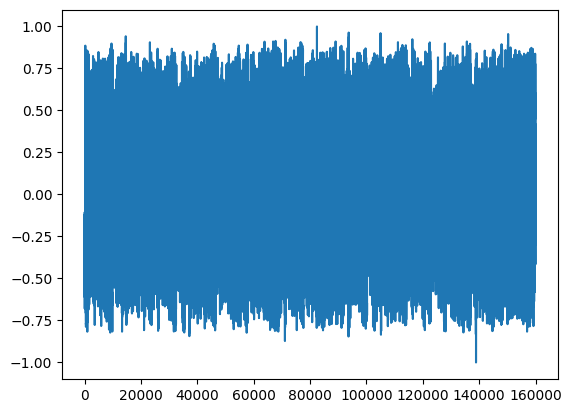

In [6]:
audio_pathes = {
    1:"audio/invertibility/ashcraft-divae-matris.wav",
    2:"audio/invertibility/ashcraft-pathes-of-words.mp3",
    3:"audio/invertibility/15033000.mp3",
    4:"audio/invertibility/16366200.mp3",
    5:"audio/invertibility/16129994.mp3",
    6:"audio/invertibility/16176213.mp3",
    7:"audio/invertibility/stellardrone-billions-and-billions.mp3"
}

audio_path = audio_pathes[5]
#audio_path = "audio/space-of-soul.mp3"
#audio_path = "audio/backwhen-watermane-deep-water.mp3"
waveform = audio_loader.load(audio_path, offset=10, duration=10)

plt.plot(waveform[0])
ipd.Audio(waveform, rate=SAMPLE_RATE, autoplay=False)

In [7]:
q_bits = 16
tokenizer = Tokenizer(q_bits=q_bits, use_mulaw_companding=True)

wav_in tensor(-1.) tensor(1.)
spec tensor(-0.4135) tensor(0.4435)
wav_ou tensor(-1.0251) tensor(1.0000)


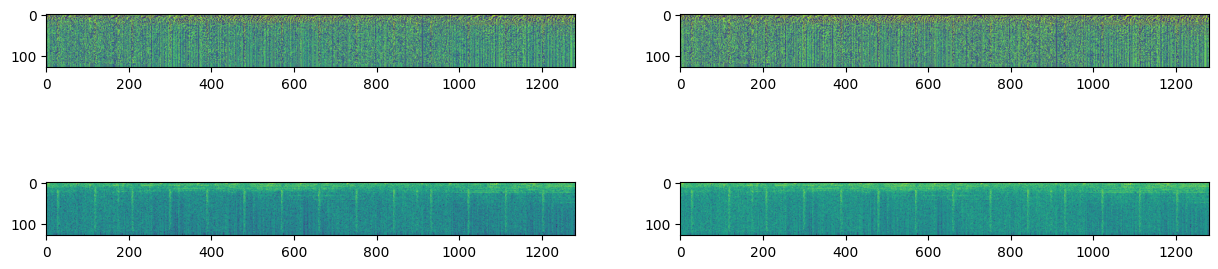

In [8]:
with torch.no_grad():
    # trnsform the waveform into tensor
    wav = torch.from_numpy(waveform).to(device).float()
    print("wav_in", wav.min(), wav.max())

    #encode and decode waveform
    s = sinc.encode(wav.unsqueeze(0))
    print("spec", s.min(), s.max())

    #s = s[:,:2]
    reconstructed_wav = sinc.decode(s)
    print("wav_ou", reconstructed_wav.min(), reconstructed_wav.max())


    #apply tokenizer
    sq = tokenizer(s)
    sr = tokenizer.inverse(sq)
    detokenized_wav = sinc.decode(sr)

    #apply mu-law-companding for visualization
    s = compute_forward_mu_law_companding(s, q_bits=q_bits)
    sr = compute_forward_mu_law_companding(sr, q_bits=q_bits)


f, axes = plt.subplots(2, 2, figsize=(15, 4))
y = s[0].detach().numpy()
yr = sr[0].detach().numpy()

axes[0,0].imshow(y)
axes[1,0].imshow(np.abs(y))

axes[0,1].imshow(yr)
axes[1,1].imshow(np.abs(yr))

# Create your Audio objects
audio1 = ipd.Audio(reconstructed_wav, rate=SAMPLE_RATE, autoplay=False)
audio2 = ipd.Audio(detokenized_wav, rate=SAMPLE_RATE, autoplay=False)
# Embed them in HTML with flexbox for horizontal layout
html_content = f"""
<div style="display:flex; justify-content:space-around;">
    <div>
        <h3>Reconstructed waveform</h3>
        {audio1._repr_html_()}
    </div>
    <div>
        <h3>Detokenized waveform</h3>
        {audio2._repr_html_()}
    </div>
</div>
"""
# Display the HTML
display(HTML(html_content))

## 2 - Linearity Test

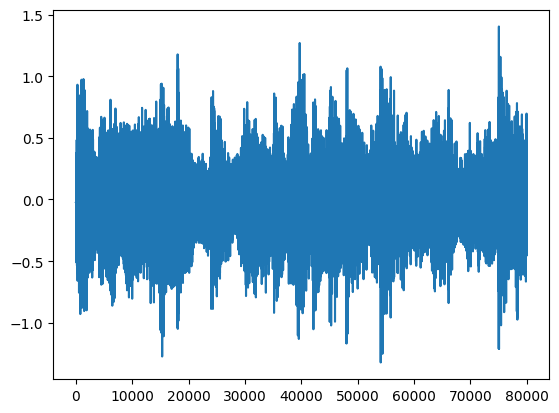

In [9]:
audio_pathes = {
    0:"audio/stems/stem_pad.wav",
    1:"audio/stems/stem_drum1.wav",
    2:"audio/stems/stem_drum2.wav",

}

selection = [0,1]

wavs = []
for choice in selection:
    audio_path = audio_pathes[choice]
    waveform = audio_loader.load(audio_path, offset=0, duration=5)
    wavs.append(waveform)

mix = sum(wavs)
wavs.insert(0, mix)

plt.plot(mix[0])
ipd.Audio(mix, rate=SAMPLE_RATE, autoplay=False)

In [10]:
spectrograms = []
reconstructed = []

with torch.no_grad():
    for i, waveform in enumerate(wavs):
        x = torch.from_numpy(waveform).to(device)
        s = sinc.encode(x)
        spectrograms.append(s)
        wav = sinc.decode(s)
        reconstructed.append(wav)

        display(ipd.Audio(waveform, rate=SAMPLE_RATE, autoplay=False))

In [17]:
s_mix_true = spectrograms[0]
s_mix_linear = torch.cat(spectrograms[1:], dim=0).sum(dim=0)
assert torch.allclose(s_mix_true, s_mix_linear, rtol=1e-3)